In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import time
import warnings
warnings.filterwarnings('ignore')

In [4]:
url='financial_regression.csv'
df=pd.read_csv(url,sep=',')
df.shape

(3904, 47)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                3904 non-null   object 
 1   sp500 open          3719 non-null   float64
 2   sp500 high          3719 non-null   float64
 3   sp500 low           3719 non-null   float64
 4   sp500 close         3719 non-null   float64
 5   sp500 volume        3719 non-null   float64
 6   sp500 high-low      3719 non-null   float64
 7   nasdaq open         3719 non-null   float64
 8   nasdaq high         3719 non-null   float64
 9   nasdaq low          3719 non-null   float64
 10  nasdaq close        3719 non-null   float64
 11  nasdaq volume       3719 non-null   float64
 12  nasdaq high-low     3719 non-null   float64
 13  us_rates_%          176 non-null    float64
 14  CPI                 176 non-null    float64
 15  usd_chf             3694 non-null   float64
 16  eur_us

In [6]:
df.isnull().sum()

date                     0
sp500 open             185
sp500 high             185
sp500 low              185
sp500 close            185
sp500 volume           185
sp500 high-low         185
nasdaq open            185
nasdaq high            185
nasdaq low             185
nasdaq close           185
nasdaq volume          185
nasdaq high-low        185
us_rates_%            3728
CPI                   3728
usd_chf                210
eur_usd                210
GDP                   3847
silver open            185
silver high            185
silver low             185
silver close           185
silver volume          185
silver high-low        185
oil open               185
oil high               185
oil low                185
oil close              185
oil volume             185
oil high-low           185
platinum open          185
platinum high          185
platinum low           185
platinum close         185
platinum volume        185
platinum high-low      185
palladium open         185
p

In [7]:
def preprocesar_dataframe_financiero(df):
    # Asegurar tipo de fecha correcto
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    # Seleccionar columnas necesarias
    columnas_montos = ['sp500 close', 'nasdaq close', 'silver close', 'oil close',
                       'platinum close', 'palladium close', 'gold close']
    df = df[['date'] + columnas_montos]

    # Ordenar por fecha
    df = df.sort_values('date')

    # Rellenar NaN con promedio de 2 anteriores
    for col in columnas_montos:
        promedio_anterior = df[col].shift(1).rolling(2).mean()
        df[col] = df[col].fillna(promedio_anterior)

    # Crear columnas de fecha
    df['dia_semana_español'] = df['date'].dt.day_name(locale='es')
    df['dia_semana'] = df['date'].dt.day_of_week
    df['dia'] = df['date'].dt.day
    df['año'] = df['date'].dt.year
    df['mes'] = df['date'].dt.month
    df['Cuatrimestre'] = df['date'].dt.quarter

    # Verificar frecuencia diaria
    diferencias = df['date'].diff().dropna()
    es_diaria = (diferencias == pd.Timedelta(days=1)).all()
    print("¿La serie tiene frecuencia diaria?", es_diaria)

    # Asegurar frecuencia diaria: reindexar
    df = df.set_index('date').sort_index()
    rango_diario = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(rango_diario)
    df.index.name = 'date'
    print("✅ Fechas completadas. Ahora puedes aplicar interpolación o relleno.")

    # Rellenar valores faltantes con promedio de 2 anteriores
    for col in columnas_montos:
        promedio_anterior = df[col].shift(1).rolling(2).mean()
        df[col] = df[col].fillna(promedio_anterior)

    # Interpolación lineal
    df[columnas_montos] = df[columnas_montos].interpolate()

    # Volver a generar las columnas temporales en el nuevo índice
    df = df.reset_index().rename(columns={'index': 'date'})
    df['dia_semana_español'] = df['date'].dt.day_name(locale='es')
    df['dia_semana'] = df['date'].dt.day_of_week
    df['dia'] = df['date'].dt.day
    df['año'] = df['date'].dt.year
    df['mes'] = df['date'].dt.month
    df['Cuatrimestre'] = df['date'].dt.quarter

    print("📅 Frecuencia inferida:", pd.infer_freq(df['date']))

    return df

df_procesado=preprocesar_dataframe_financiero(df)
df_procesado

¿La serie tiene frecuencia diaria? False
✅ Fechas completadas. Ahora puedes aplicar interpolación o relleno.
📅 Frecuencia inferida: D


,date,sp500 close,nasdaq close,silver close,oil close,platinum close,palladium close,gold close,dia_semana_español,dia_semana,dia,año,mes,Cuatrimestre
0,2010-01-14,114.930,46.39,18.6600,39.06,161.45,44.84,112.030,Jueves,3,14,2010,1,1
1,2010-01-15,113.640,45.85,18.4100,38.40,160.25,45.76,110.860,Viernes,4,15,2010,1,1
2,2010-01-16,114.285,46.12,18.5350,38.73,160.85,45.30,111.445,Sábado,5,16,2010,1,1
3,2010-01-17,114.285,46.12,18.5350,38.73,160.85,45.30,111.445,Domingo,6,17,2010,1,1
4,2010-01-18,114.285,46.12,18.5350,38.73,160.85,45.30,111.445,Lunes,0,18,2010,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5392,2024-10-19,583.470,492.86,31.1850,72.00,92.07,97.57,249.950,Sábado,5,19,2024,10,4
5393,2024-10-20,583.550,494.14,31.7525,72.13,92.17,97.46,250.585,Domingo,6,20,2024,10,4
5394,2024-10-21,583.630,495.42,32.3200,72.26,92.27,97.35,251.220,Lunes,0,21,2024,10,4
5395,2024-10-22,583.320,495.96,33.2300,73.98,94.51,99.41,253.930,Martes,1,22,2024,10,4


In [8]:
df_procesado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5397 entries, 0 to 5396
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                5397 non-null   datetime64[ns]
 1   sp500 close         5397 non-null   float64       
 2   nasdaq close        5397 non-null   float64       
 3   silver close        5397 non-null   float64       
 4   oil close           5397 non-null   float64       
 5   platinum close      5397 non-null   float64       
 6   palladium close     5397 non-null   float64       
 7   gold close          5397 non-null   float64       
 8   dia_semana_español  5397 non-null   object        
 9   dia_semana          5397 non-null   int32         
 10  dia                 5397 non-null   int32         
 11  año                 5397 non-null   int32         
 12  mes                 5397 non-null   int32         
 13  Cuatrimestre        5397 non-null   int32       

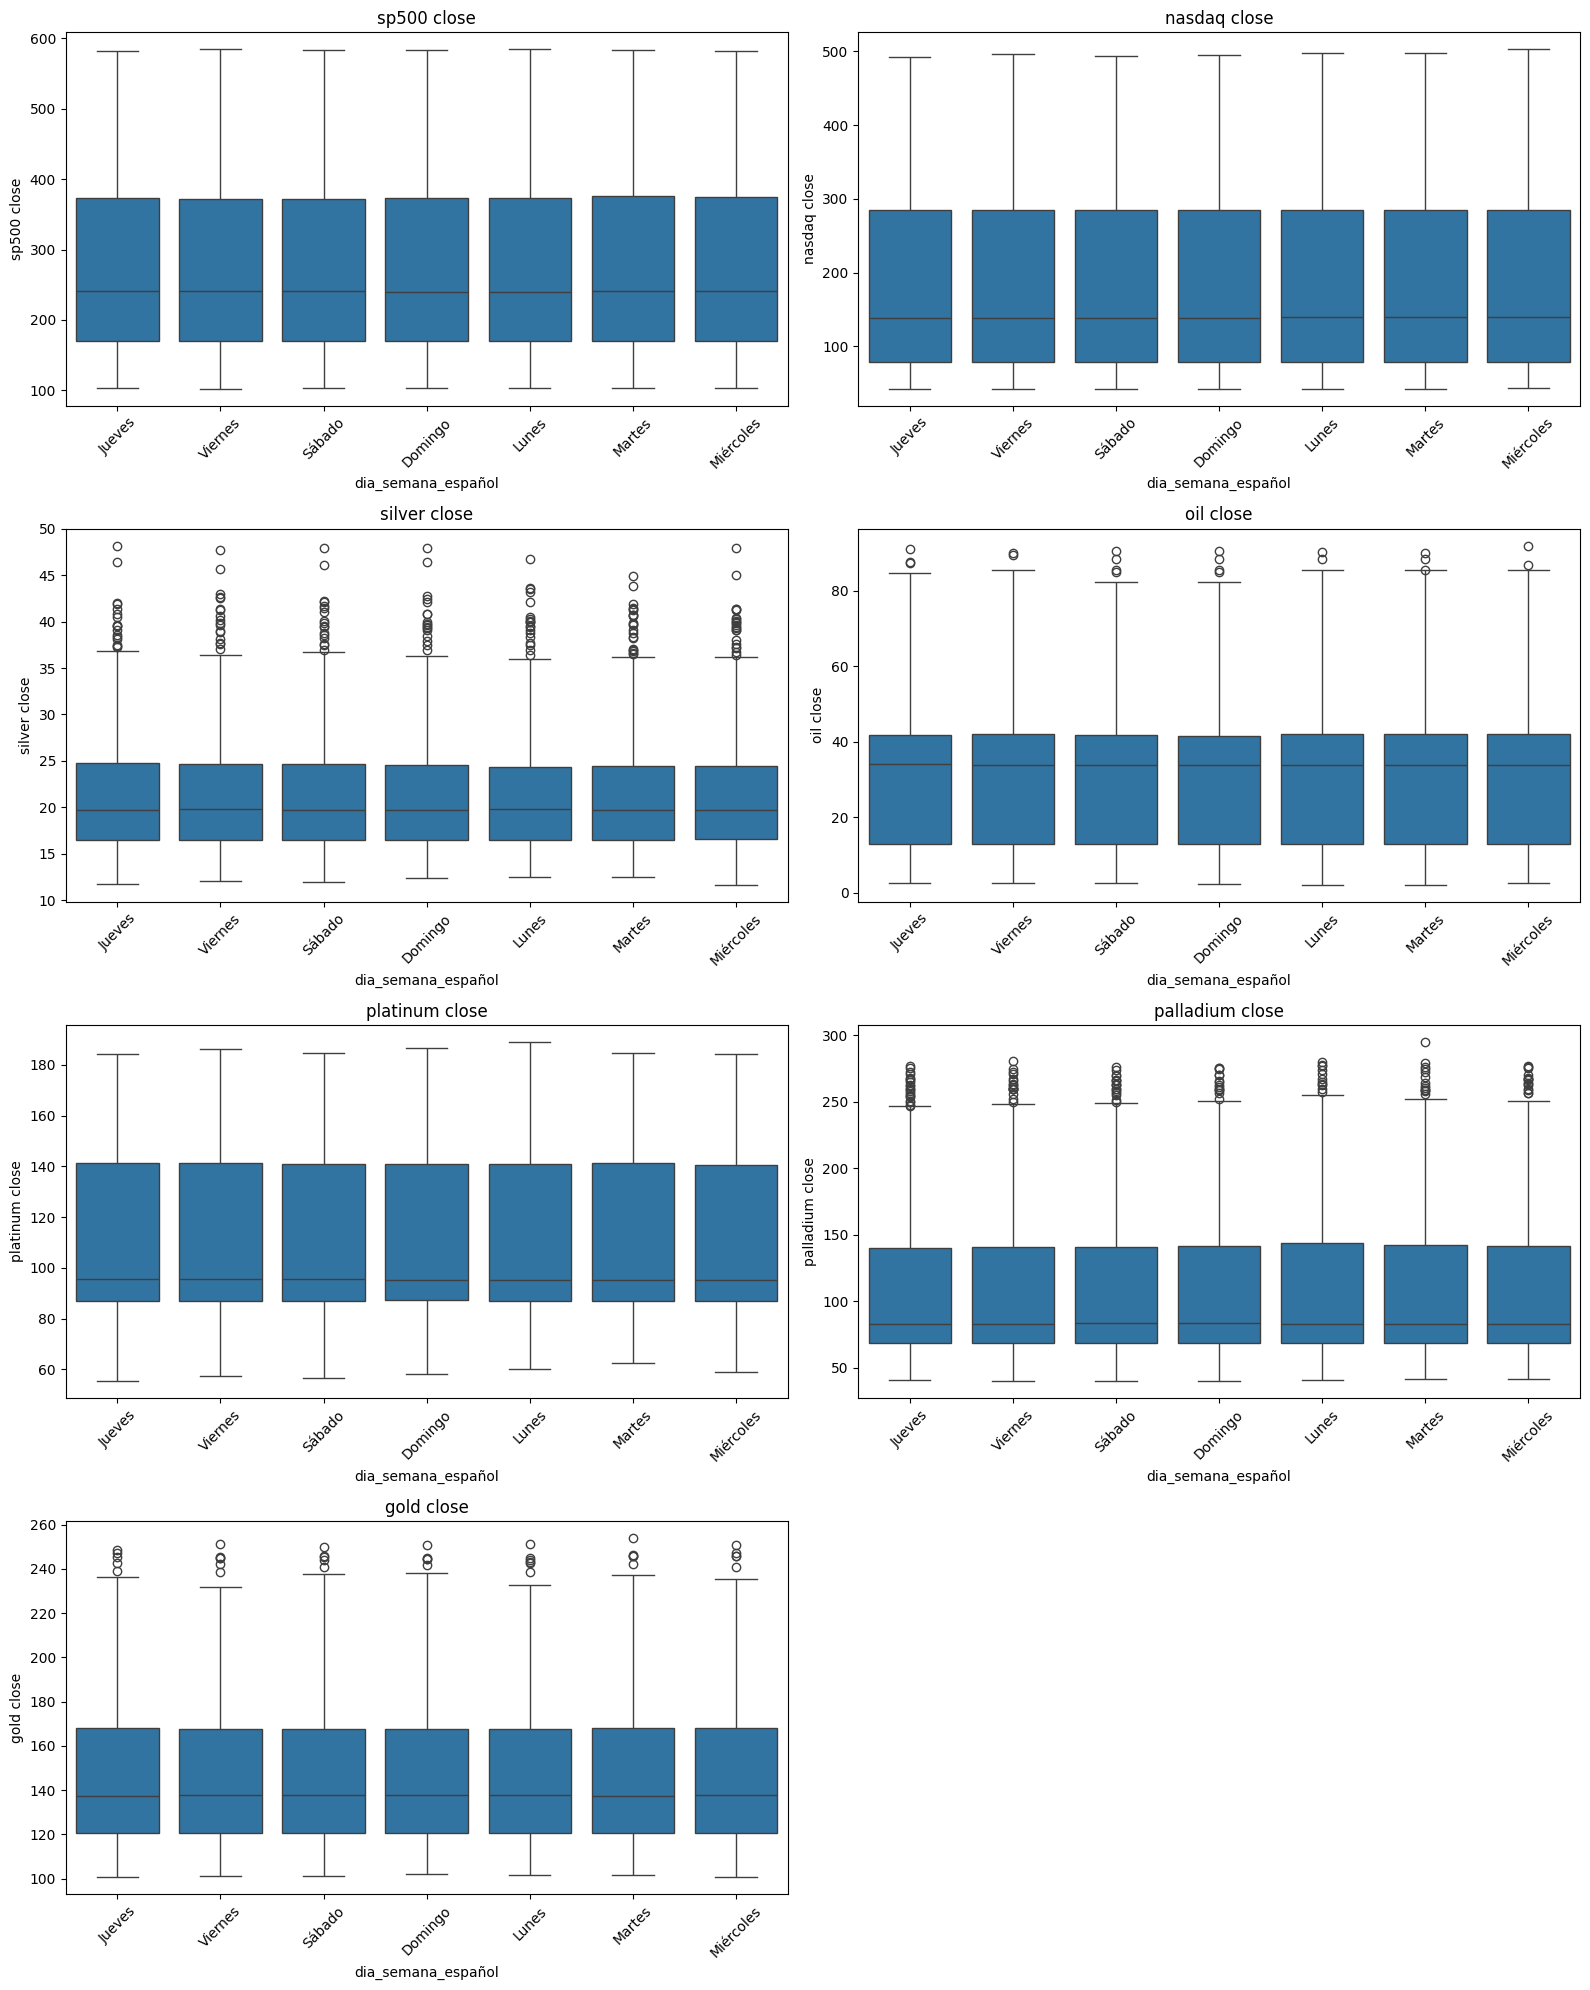

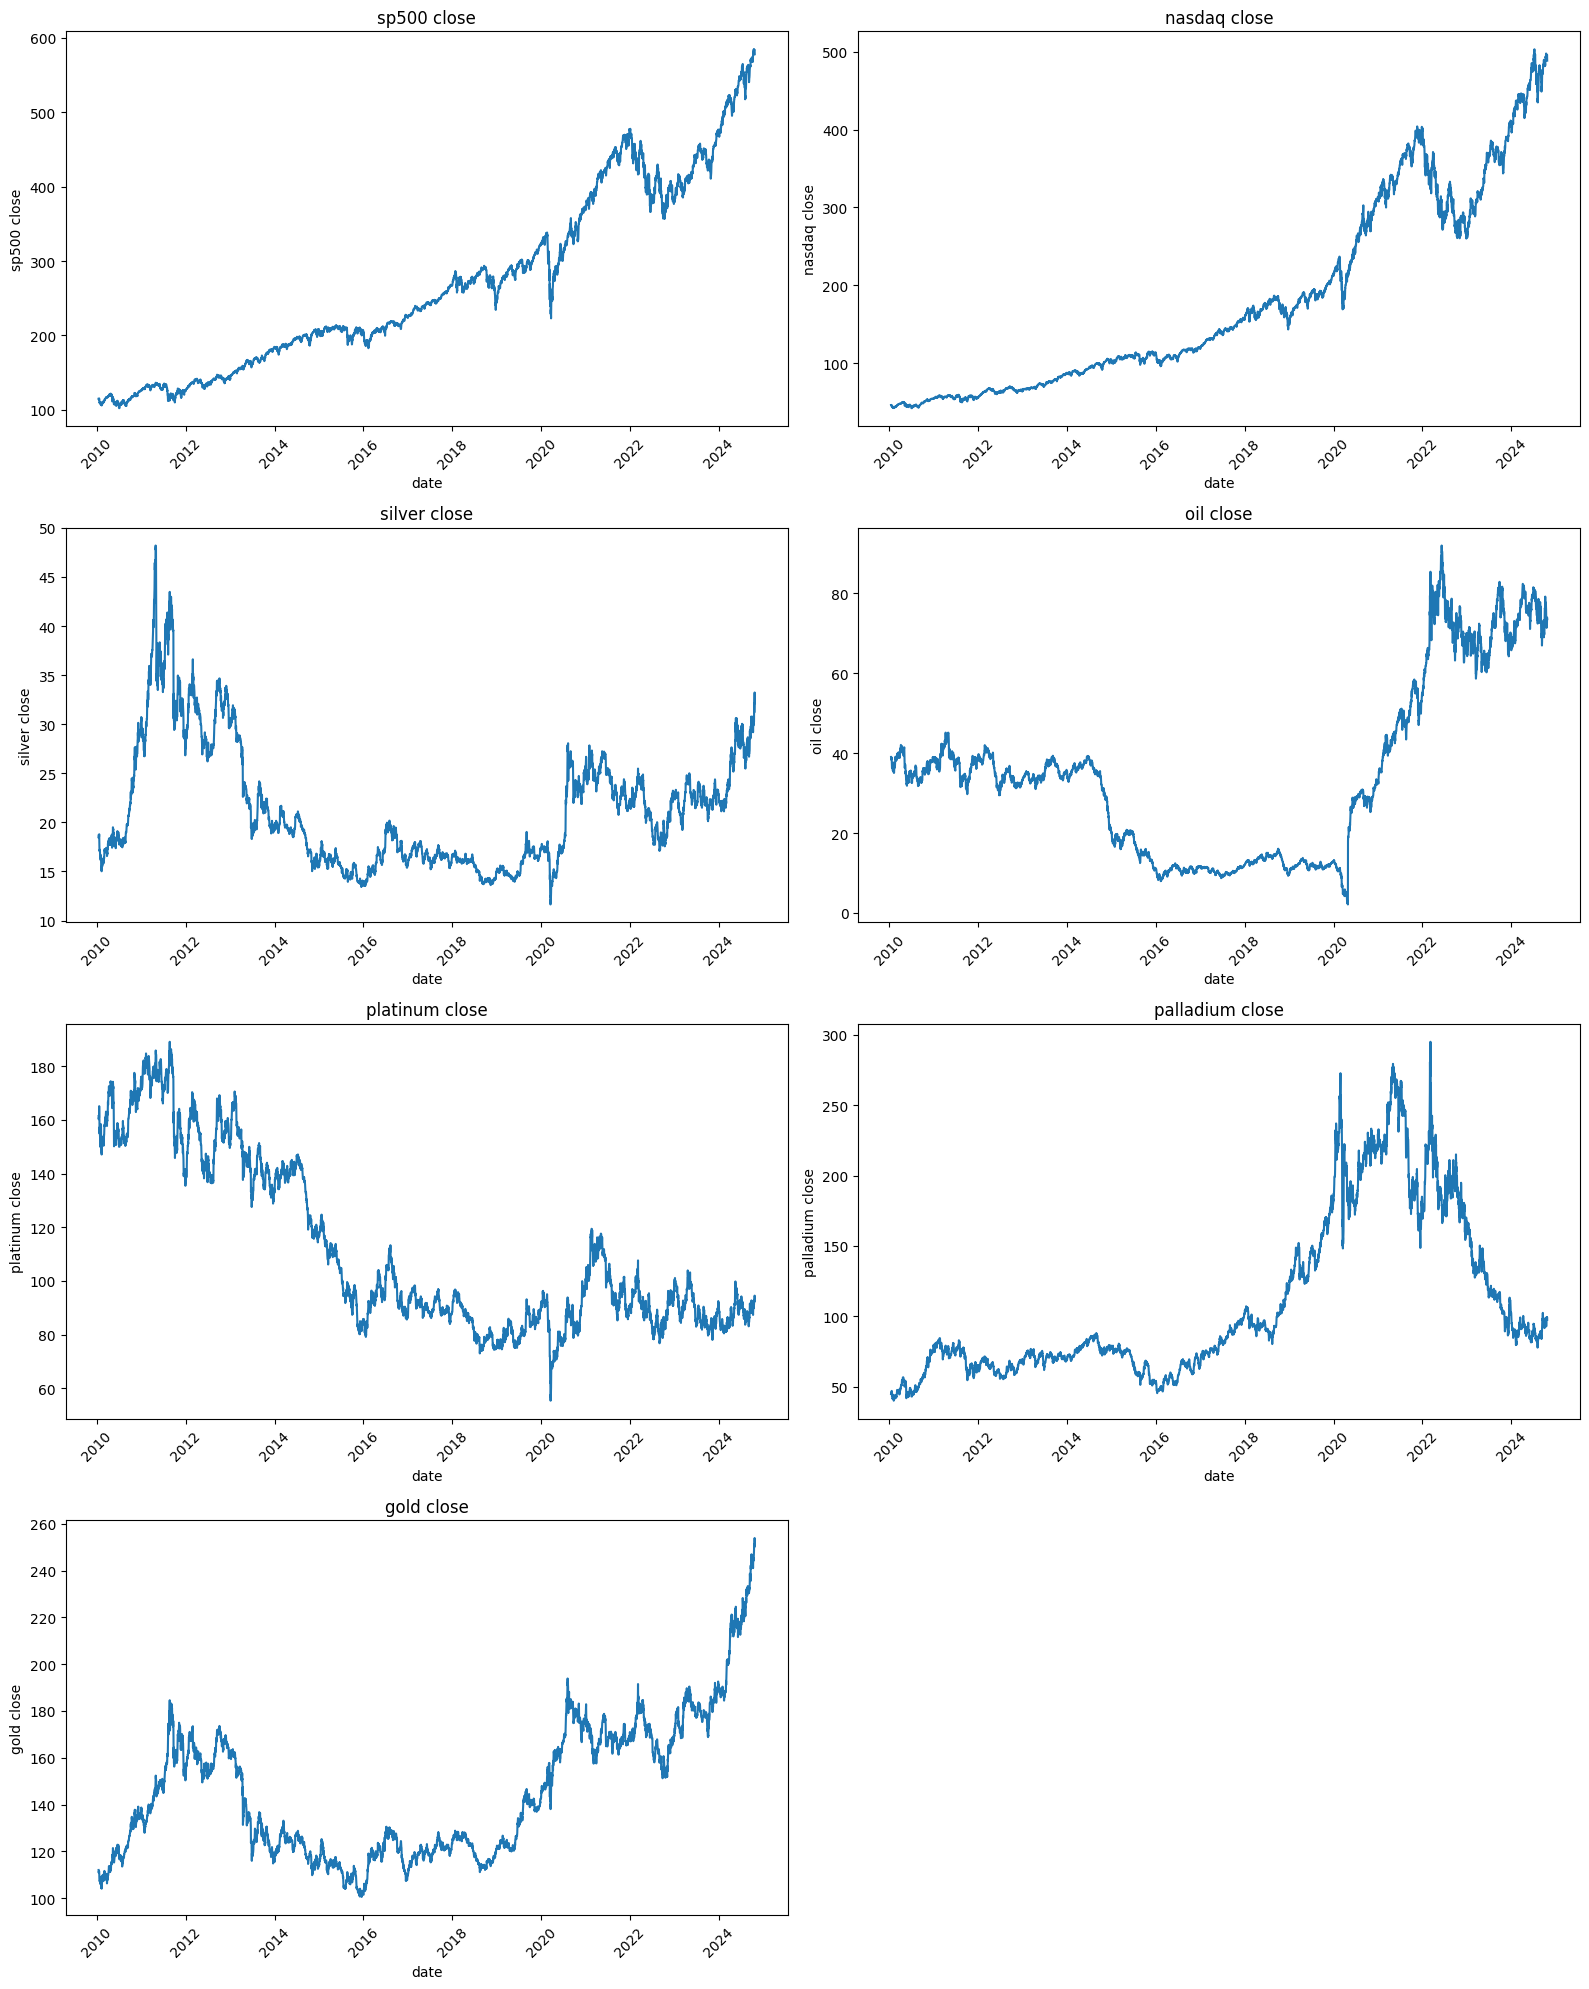

In [9]:
columnas_montos = ['sp500 close', 'nasdaq close', 'silver close', 'oil close',
                       'platinum close', 'palladium close', 'gold close']
# Crear figura y ejes: 4 filas x 2 columnas
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
axes = axes.flatten()  # Convertir en lista plana

# Graficar cada serie
for idx, col in enumerate(columnas_montos):
    sns.boxplot(data=df_procesado, x='dia_semana_español', y=col, ax=axes[idx])
    axes[idx].set_title(col)
    axes[idx].tick_params(axis='x', rotation=45)

# Eliminar el eje vacío (el 8º gráfico que no usamos)
if len(columnas_montos) < len(axes):
    for j in range(len(columnas_montos), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()




# Crear figura y ejes: 4 filas x 2 columnas
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
axes = axes.flatten()  # Convertir en lista plana

# Graficar cada serie
for idx, col in enumerate(columnas_montos):
    sns.lineplot(data=df_procesado, x='date', y=col, ax=axes[idx])
    axes[idx].set_title(col)
    axes[idx].tick_params(axis='x', rotation=45)

# Eliminar el eje vacío (el 8º gráfico que no usamos)
if len(columnas_montos) < len(axes):
    for j in range(len(columnas_montos), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [13]:
df_procesado

,date,sp500 close,nasdaq close,silver close,oil close,platinum close,palladium close,gold close,dia_semana_español,dia_semana,dia,año,mes,Cuatrimestre
0,2010-01-14,114.930,46.39,18.6600,39.06,161.45,44.84,112.030,Jueves,3,14,2010,1,1
1,2010-01-15,113.640,45.85,18.4100,38.40,160.25,45.76,110.860,Viernes,4,15,2010,1,1
2,2010-01-16,114.285,46.12,18.5350,38.73,160.85,45.30,111.445,Sábado,5,16,2010,1,1
3,2010-01-17,114.285,46.12,18.5350,38.73,160.85,45.30,111.445,Domingo,6,17,2010,1,1
4,2010-01-18,114.285,46.12,18.5350,38.73,160.85,45.30,111.445,Lunes,0,18,2010,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5392,2024-10-19,583.470,492.86,31.1850,72.00,92.07,97.57,249.950,Sábado,5,19,2024,10,4
5393,2024-10-20,583.550,494.14,31.7525,72.13,92.17,97.46,250.585,Domingo,6,20,2024,10,4
5394,2024-10-21,583.630,495.42,32.3200,72.26,92.27,97.35,251.220,Lunes,0,21,2024,10,4
5395,2024-10-22,583.320,495.96,33.2300,73.98,94.51,99.41,253.930,Martes,1,22,2024,10,4


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,603 (68.76 KB)

 Trainable params: 17,603 (68.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0097 - val_loss: 6.2005e-04
Epoch 2/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.8181e-04 - val_loss: 4.5857e-04
Epoch 3/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 1.4944e-04 - val_loss: 7.1353e-04
Epoch 4/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 1.2250e-04 - val_loss: 4.4823e-04
Epoch 5/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.1140e-04 - val_loss: 5.4424e-04
Epoch 6/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.0797e-04 - val_loss: 5.9765e-04
Epoch 7/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 9.2072e-05 - val_loss: 8.3824e-04
Epoch 8/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 9.7404e-05 - val_loss: 6.4428e-04
Epoch 9/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 8.6633e-05 - val_loss: 6.3929e-04
Epoch 10/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 8.4752e-05 - val_loss: 7.7099e-04
Epoch 11/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step

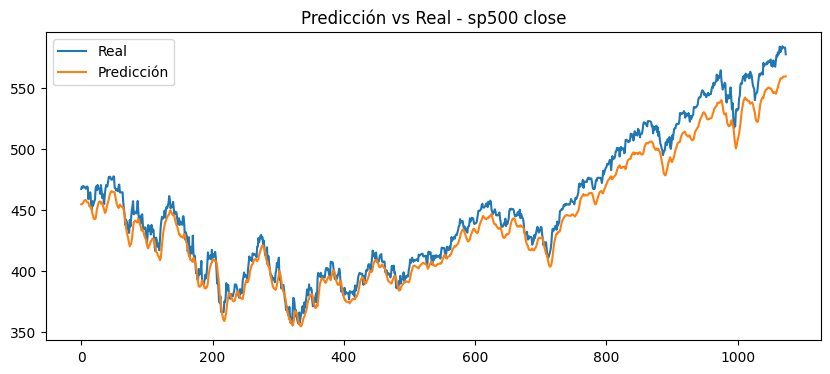

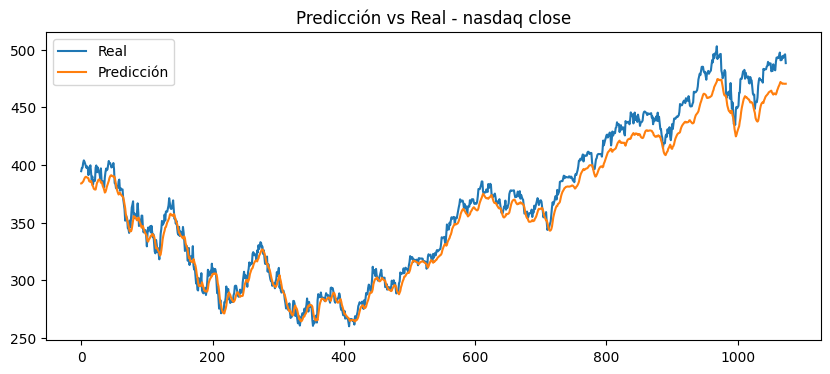

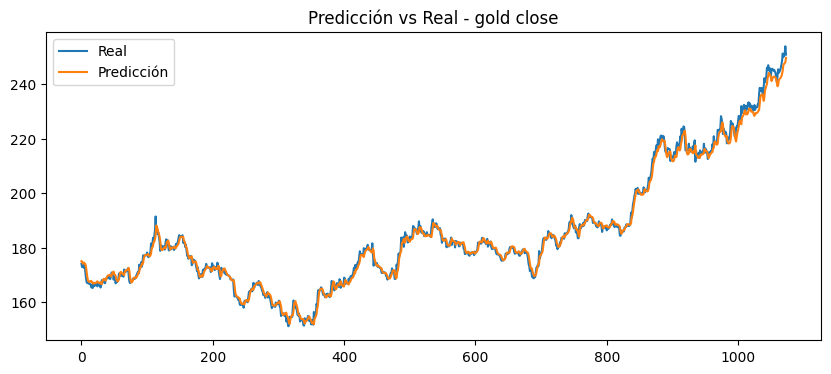

In [14]:
# 1. Selección de columnas objetivo y normalización
target_cols = ['sp500 close', 'nasdaq close', 'gold close']
data=df_procesado[target_cols].values
scaler=MinMaxScaler()
data_scaled=scaler.fit_transform(data)
# 2. Crear secuencias para LSTM
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

sequence_length = 30  # 30 días para predecir el siguiente
X, y = create_sequences(data_scaled, sequence_length)

# 3. División de datos
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 4. Definición del modelo LSTM multisalida
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(sequence_length, len(target_cols))))
model.add(Dense(3))  # Tres salidas: S&P 500, Nasdaq, Oro

model.compile(optimizer='adam', loss='mse')
model.summary()

# 5. Entrenamiento
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)

# 6. Predicción
y_pred = model.predict(X_test)

# 7. Inversión de escala (sin concatenación)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)


# 8. Gráfico de resultados
for i, col in enumerate(target_cols):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inv[:, i], label='Real')
    plt.plot(y_pred_inv[:, i], label='Predicción')
    plt.title(f'Predicción vs Real - {col}')
    plt.legend()
    plt.show()

In [ ]:
# 9. Métricas de evaluación
def calcular_metricas(y_true, y_pred, nombre_variable):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📊 Resultados para {nombre_variable}:")
    print(f"MAE  = {mae:.4f}")
    print(f"MSE  = {mse:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"R²   = {r2:.4f}")


for i, nombre in enumerate(['sp500 close', 'nasdaq close', 'gold close']): 
    calcular_metricas(y_test_inv[:, i], y_pred_inv[:, i], nombre)



📊 Resultados para sp500 close:
MAE  = 11.0664
MSE  = 167.7690
RMSE = 12.9526
R²   = 0.9476

📊 Resultados para nasdaq close:
MAE  = 9.3922
MSE  = 138.3674
RMSE = 11.7630
R²   = 0.9685

📊 Resultados para gold close:
MAE  = 1.2102
MSE  = 2.8811
RMSE = 1.6974
R²   = 0.9942
